# Biomedical Image Segmentation using U-Net Architecture - CUDA

## Step-1 - Checking CUDA Compatability

In [1]:
print("Hello From Cuda")

Hello From Cuda


In [2]:
!nvidia-smi

Sat Jan  4 08:47:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0             14W /  130W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Step-2 - Getting Dependencies and dataset

In [7]:
import torch.nn as nn
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import time
import os
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from utils.img_loader import *
import deeplake

## Step-3 - Loading Dataset

In [8]:
# Load the DRIVE training dataset
train_ds = deeplake.load("hub://activeloop/drive-train")

# Load the DRIVE testing dataset
test_ds = deeplake.load("hub://activeloop/drive-test")

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/drive-train



-

hub://activeloop/drive-train loaded successfully.



|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/drive-test



|

hub://activeloop/drive-test loaded successfully.



In [9]:
print(train_ds.summary())  # Overview of the training dataset
print(test_ds.summary())   # Overview of the testing dataset

Dataset(path='hub://activeloop/drive-train', read_only=True, tensors=['rgb_images', 'manual_masks/mask', 'masks/mask'])

      tensor           htype           shape         dtype  compression
      -------         -------         -------       -------  ------- 
    rgb_images         image     (20, 584, 565, 3)   uint8    tiff   
 manual_masks/mask  binary_mask  (20, 584, 565, 2)   bool      lz4   
    masks/mask      binary_mask  (20, 584, 565, 2)   bool      lz4   
None
Dataset(path='hub://activeloop/drive-test', read_only=True, tensors=['rgb_images', 'masks'])

   tensor       htype           shape         dtype  compression
  -------      -------         -------       -------  ------- 
 rgb_images     image     (20, 584, 565, 3)   uint8    tiff   
   masks     binary_mask  (20, 584, 565, 2)   bool      lz4   
None


In [11]:
# Create DataLoaders for training and testing datasets
train_loader = train_ds.pytorch(
    num_workers=4,  # Adjust for your system
    batch_size=4,
    shuffle=False
)

test_loader = test_ds.pytorch(
    num_workers=4,  # Adjust for your system
    batch_size=4,
    shuffle=False
)

In [12]:
for batch in train_loader:
    # Extract images and masks
    images = batch["rgb_images"]
    masks = batch["manual_masks/mask"]

    # Move to the GPU/CPU
    images = images.to(device)
    masks = masks.to(device)

    # Use in your training loop
    print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")
    break

Images shape: torch.Size([4, 584, 565, 3]), Masks shape: torch.Size([4, 584, 565, 2])


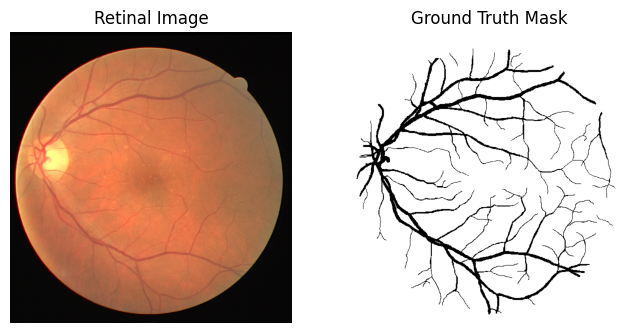

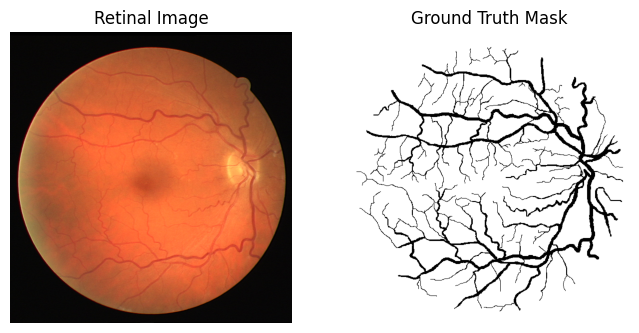

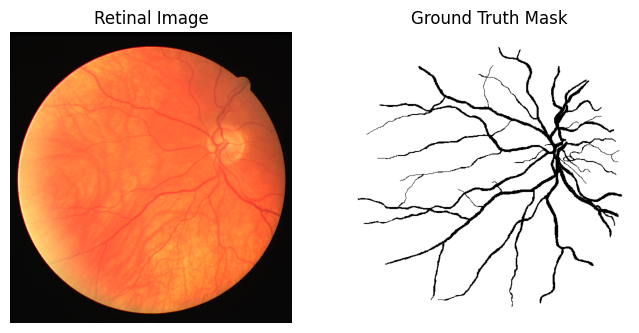

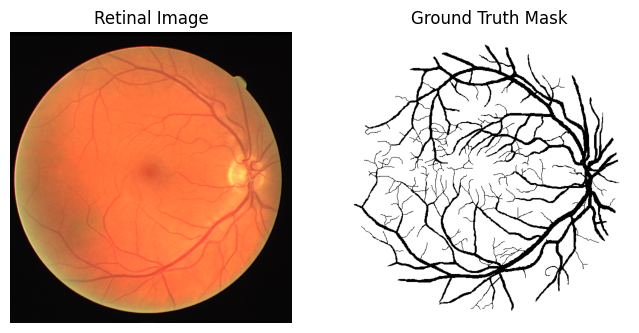

In [15]:
import matplotlib.pyplot as plt

def visualize_sample(batch):
    for i in range(len(batch["rgb_images"])):
        # Extract image and mask
        image = batch["rgb_images"][i].numpy()  # Already in HWC format
        mask = batch["manual_masks/mask"][i][:, :, 0].numpy()  # Use the first channel of the mask

        plt.figure(figsize=(8, 4))

        # Plot image
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Retinal Image")
        plt.axis("off")

        # Plot mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.show()

# Visualize a batch
for batch in train_loader:
    visualize_sample(batch)
    break

In [45]:
# train_dir = "dataset/train"
# images = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith(".tif") and not f.endswith("_mask.tif")])
# masks = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith("_mask.tif")])

In [46]:
# train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# import matplotlib.pyplot as plt
# import random

# def display_random_samples(images, masks, num_samples=5):
#     indices = random.sample(range(len(images)), num_samples)
#     fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
#     for i, idx in enumerate(indices):
#         image = images[idx]  # Get image
#         mask = masks[idx]    # Get corresponding mask
        
#         if isinstance(image, str):  # If paths are given, read the image
#             image = plt.imread(image)
#             mask = plt.imread(mask)
        
#         # Show the image
#         axes[i, 0].imshow(image, cmap='gray' if image.ndim == 2 else None)
#         axes[i, 0].set_title(f"Image {idx}")
#         axes[i, 0].axis("off")
        
#         # Show the mask
#         axes[i, 1].imshow(mask, cmap='gray')
#         axes[i, 1].set_title(f"Mask {idx}")
#         axes[i, 1].axis("off")
    
#     plt.tight_layout()
#     plt.show()

# # Display random samples from the training data
# display_random_samples(train_images, train_masks, num_samples=3)

In [48]:
# train_dataset = SegmentationDataset(train_images, train_masks, transform=ImageMaskTransform(size=(256, 256)))
# val_dataset = SegmentationDataset(val_images, val_masks, transform=ImageMaskTransform(size=(256, 256)))

## Step-4 - Loading U-Net Model
<img src="img/U-net.png" alt="U-net" width = "700px" height = "450px">

In [49]:
batch_size = 16
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True, 
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

In [17]:
from Unet import UNet

In [18]:
# Parameters
n_channels = 3  # Number of input channels (e.g., RGB images)
n_classes = 1   # Number of output channels (e.g., binary segmentation)

# Model instantiation
model = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True)

# Move model to GPU if available
model.to(device)

print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

## Step-5 - Training U-Net Model

In [52]:
loss_fn = nn.BCEWithLogitsLoss()  # Combines sigmoid activation and BCE

In [65]:
def predict(model, images):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        predictions = (predictions > 0.5).float()  # Convert to binary mask
    return predictions

In [54]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        # Forward pass with checkpointing
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f"Batch {i + 1}/{len(train_loader)} Loss: {loss.item():.4f}")

    return running_loss / len(train_loader)

In [55]:
def validate_one_epoch(val_loader, model, loss_fn, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    return val_loss / len(val_loader)

In [56]:
scaler = torch.amp.GradScaler('cuda')  # Use scaler for mixed precision training

def train_one_epoch_amp(train_loader, model, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):  # Automatic Mixed Precision
            outputs = model(images)
            loss = loss_fn(outputs, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f"Batch {i + 1}/{len(train_loader)} Loss: {loss.item():.4f}")

    return running_loss / len(train_loader)

In [57]:
num_epochs = 5
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train for one epoch
    train_loss = train_one_epoch_amp(train_loader, model, optimizer, loss_fn, device)
    print(f"Training Loss: {train_loss:.4f}")

    # Validate after each epoch
    val_loss = validate_one_epoch(val_loader, model, loss_fn, device)
    print(f"Validation Loss: {val_loss:.4f}")
    scheduler.step()

Epoch 1/5
Batch 10/282 Loss: 0.4146
Batch 20/282 Loss: 0.3056
Batch 30/282 Loss: 0.2592
Batch 40/282 Loss: 0.2270
Batch 50/282 Loss: 0.1968
Batch 60/282 Loss: 0.1710
Batch 70/282 Loss: 0.1486
Batch 80/282 Loss: 0.1403
Batch 90/282 Loss: 0.1367
Batch 100/282 Loss: 0.1196
Batch 110/282 Loss: 0.1076
Batch 120/282 Loss: 0.0976
Batch 130/282 Loss: 0.0957
Batch 140/282 Loss: 0.0809
Batch 150/282 Loss: 0.0914
Batch 160/282 Loss: 0.0743
Batch 170/282 Loss: 0.0586
Batch 180/282 Loss: 0.0678
Batch 190/282 Loss: 0.0799
Batch 200/282 Loss: 0.0632
Batch 210/282 Loss: 0.0622
Batch 220/282 Loss: 0.0562
Batch 230/282 Loss: 0.0493
Batch 240/282 Loss: 0.0766
Batch 250/282 Loss: 0.0781
Batch 260/282 Loss: 0.0729
Batch 270/282 Loss: 0.0524
Batch 280/282 Loss: 0.0453
Training Loss: 0.1297
Validation Loss: 0.0544
Epoch 2/5
Batch 10/282 Loss: 0.0434
Batch 20/282 Loss: 0.0714
Batch 30/282 Loss: 0.0656
Batch 40/282 Loss: 0.0456
Batch 50/282 Loss: 0.0459
Batch 60/282 Loss: 0.0586
Batch 70/282 Loss: 0.0585
Batch

## Step-6 - Evaluating U-Net Model

In [ ]:
def test_model(test_loader, model, device):
    model.eval()
    results = []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device, non_blocking=True)
            outputs = model(images)
            results.append(outputs.cpu())
    return results
test_model(val_loader, model, device)

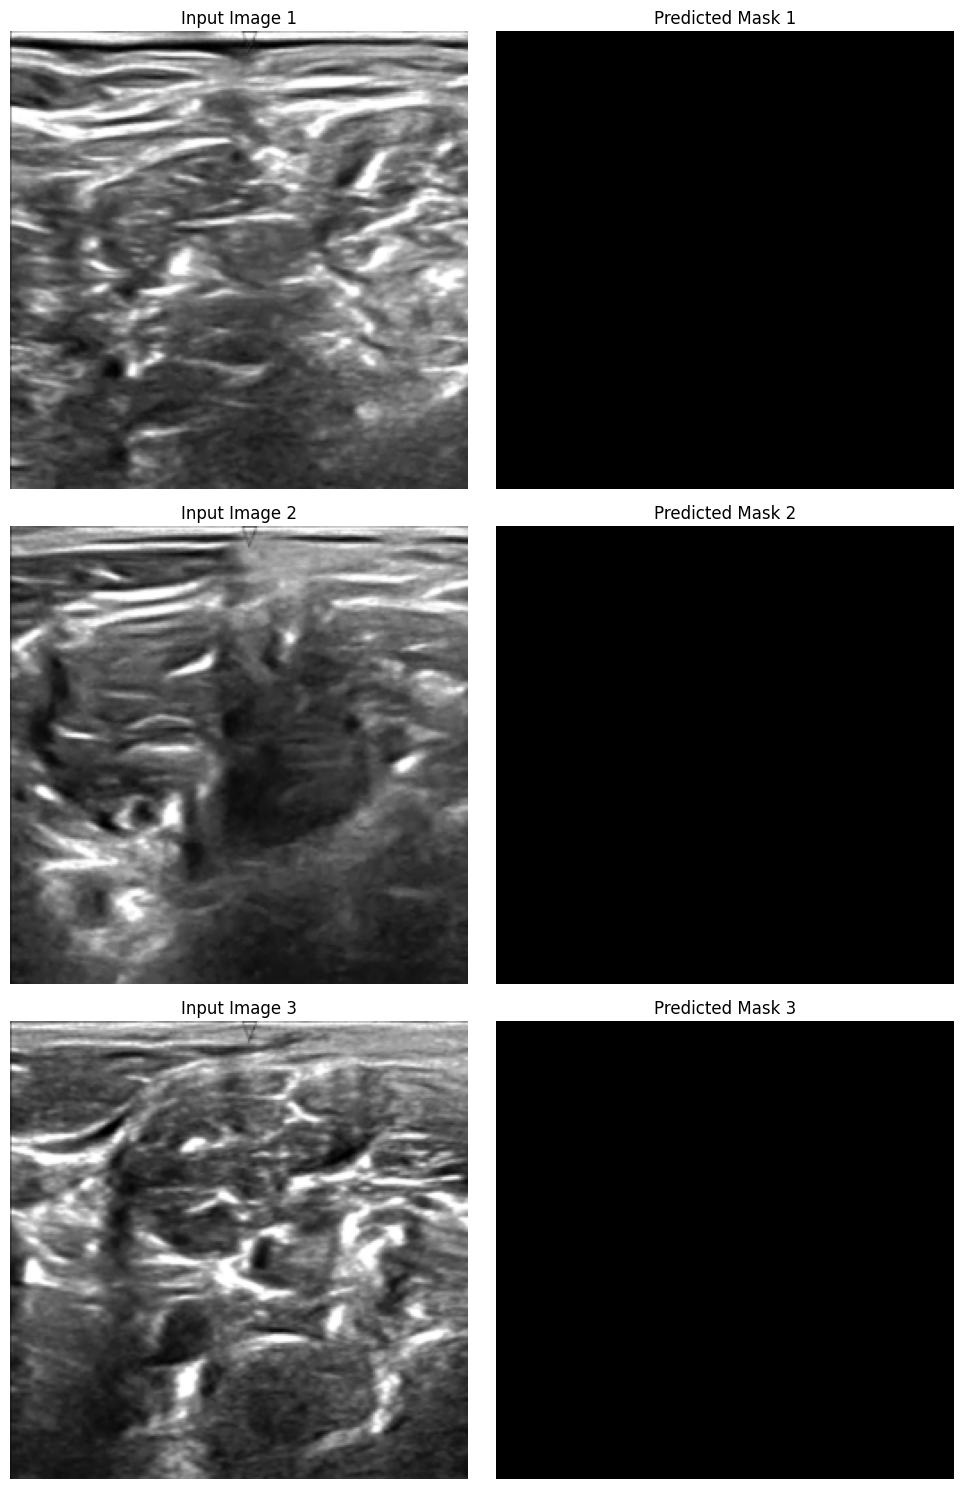

[tensor([[[[0.0014, 0.0019, 0.0017,  ..., 0.0013, 0.0013, 0.0015],
           [0.0017, 0.0016, 0.0013,  ..., 0.0009, 0.0009, 0.0011],
           [0.0017, 0.0016, 0.0013,  ..., 0.0010, 0.0009, 0.0011],
           ...,
           [0.0008, 0.0005, 0.0005,  ..., 0.0007, 0.0006, 0.0009],
           [0.0009, 0.0006, 0.0005,  ..., 0.0006, 0.0006, 0.0009],
           [0.0004, 0.0005, 0.0004,  ..., 0.0005, 0.0005, 0.0005]]],
 
 
         [[[0.0009, 0.0015, 0.0012,  ..., 0.0014, 0.0014, 0.0015],
           [0.0009, 0.0016, 0.0011,  ..., 0.0010, 0.0009, 0.0011],
           [0.0008, 0.0013, 0.0009,  ..., 0.0010, 0.0009, 0.0011],
           ...,
           [0.0007, 0.0005, 0.0005,  ..., 0.0006, 0.0006, 0.0008],
           [0.0008, 0.0005, 0.0005,  ..., 0.0005, 0.0006, 0.0009],
           [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005]]],
 
 
         [[[0.0015, 0.0019, 0.0017,  ..., 0.0016, 0.0015, 0.0015],
           [0.0021, 0.0016, 0.0014,  ..., 0.0012, 0.0011, 0.0013],
           [0.0023

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def test_model_with_masks(test_loader, model, device, num_images_to_show=5):
    """
    Test the model and visualize input images, original masks, and predictions.

    Args:
        test_loader: DataLoader for test dataset.
        model: Trained model.
        device: Device to run the model on (CPU/GPU).
        num_images_to_show: Number of images to visualize.
    """
    model.eval()
    images_to_plot = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if isinstance(batch, (list, tuple)):
                images, masks = batch  # Extract images and masks
            else:
                images = batch
                masks = None

            images = images.to(device, non_blocking=True)
            outputs = model(images)
            predictions = torch.sigmoid(outputs).cpu()  # Apply sigmoid to outputs
            
            # Collect images, original masks, and predictions
            if len(images_to_plot) < num_images_to_show:
                images_to_plot.extend(zip(images.cpu(), masks.cpu() if masks is not None else None, predictions))
            
            if len(images_to_plot) >= num_images_to_show:
                break

    # Visualize the images, original masks, and predictions
    fig, axes = plt.subplots(num_images_to_show, 3, figsize=(15, num_images_to_show * 5))
    for idx, (image, orig_mask, pred_mask) in enumerate(images_to_plot[:num_images_to_show]):
        # Convert tensor to numpy and denormalize the image
        image_np = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Assuming normalization (mean=0.5, std=0.5)
        image_np = np.clip(image_np, 0, 1)
        
        # Convert original mask and prediction to numpy for visualization
        if orig_mask is not None:
            orig_mask_np = orig_mask.squeeze().numpy()
        else:
            orig_mask_np = None
            
        pred_mask_np = (pred_mask.squeeze().numpy() > 0.5).astype(np.uint8)

        # Display input image
        axes[idx, 0].imshow(image_np)
        axes[idx, 0].axis("off")
        axes[idx, 0].set_title(f"Input Image {idx + 1}")

        # Display original mask (if available)
        if orig_mask_np is not None:
            axes[idx, 1].imshow(orig_mask_np, cmap="gray")
            axes[idx, 1].axis("off")
            axes[idx, 1].set_title(f"Original Mask {idx + 1}")
        else:
            axes[idx, 1].axis("off")
            axes[idx, 1].set_title("Original Mask Not Available")

        # Display predicted mask
        axes[idx, 2].imshow(pred_mask_np, cmap="gray")
        axes[idx, 2].axis("off")
        axes[idx, 2].set_title(f"Predicted Mask {idx + 1}")

    plt.tight_layout()
    plt.show()

    
test_model(val_loader, model, device, num_images_to_show=3)